<a href="https://colab.research.google.com/github/Bladerunnerxyz/credit_scoring_project/blob/main/credit%20score%20working%20output%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset shape: (6000, 13)
Preview:
    age  annual_income_inr  debt_to_income  credit_utilization  \
0   25             864096           0.178               0.489   
1   58             411195           0.738               0.700   
2   53             120000           0.178               0.541   
3   42             158259           0.679               0.301   
4   42             955406           0.409               0.827   

   late_payments_12m  accounts_open  loan_amount_inr  employment_length_years  \
0                  1              3           255907                       17   
1                  1              5           366204                       20   
2                  0              3           162583                        0   
3                  1              5           378910                       23   
4                  0              4            10000                        3   

   has_mortgage  is_self_employed   region  payment_history_score  default  
0        

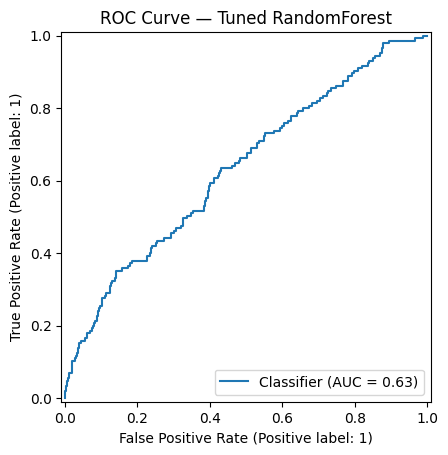

Saved tuned model to models/credit_scoring_best_model.joblib

Example applicant predicted probability of default: 0.298


In [11]:
# @title Default title text
# credit_scoring.py
# Credit Scoring Model with Hyperparameter Tuning

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
)
import joblib


# -----------------------------
# 1. Load dataset
# -----------------------------
DATA_PATH = "/content/credit_synthetic.csv"  # <-- replace with your dataset if needed
df = pd.read_csv(DATA_PATH)

print("Dataset shape:", df.shape)
print("Preview:\n", df.head(), "\n")

# Target column
target = "default"
X = df.drop(columns=[target])
y = df[target]

# Identify numeric and categorical columns
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols, "\n")

# -----------------------------
# 2. Preprocessing
# -----------------------------
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# -----------------------------
# 3. Candidate Models
# -----------------------------
models = {
    "LogisticRegression": LogisticRegression(max_iter=400, class_weight="balanced", random_state=42),
    "DecisionTree": DecisionTreeClassifier(class_weight="balanced", random_state=42),
    "RandomForest": RandomForestClassifier(class_weight="balanced", n_estimators=300, random_state=42),
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Cross-Validation ROC-AUC Scores:")
for name, clf in models.items():
    pipe = Pipeline(steps=[("preprocess", preprocess), ("clf", clf)])
    scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=-1)
    print(f"{name}: {scores.mean():.3f} ± {scores.std():.3f}")
print()

# -----------------------------
# 4. Hyperparameter Tuning (Random Forest)
# -----------------------------
param_grid = {
    "clf__n_estimators": [100, 200, 400],
    "clf__max_depth": [None, 5, 10, 20],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 4]
}

pipe_rf = Pipeline(steps=[("preprocess", preprocess),
                          ("clf", RandomForestClassifier(class_weight="balanced", random_state=42))])

grid_search = GridSearchCV(
    pipe_rf, param_grid, cv=cv, scoring="roc_auc", n_jobs=-1, verbose=2
)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best CV ROC-AUC:", grid_search.best_score_)

best_model = grid_search.best_estimator_

# -----------------------------
# 5. Final Evaluation
# -----------------------------
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Test ROC-AUC:", roc_auc_score(y_test, y_proba))

RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("ROC Curve — Tuned RandomForest")
plt.show()

# -----------------------------
# 6. Save Model
# -----------------------------
Path("models").mkdir(exist_ok=True)
joblib.dump(best_model, "models/credit_scoring_best_model.joblib")
print("Saved tuned model to models/credit_scoring_best_model.joblib")

# -----------------------------
# 7. Example Prediction
# -----------------------------
example = pd.DataFrame([{
    "age": 30, "annual_income_inr": 800000, "debt_to_income": 0.35, "credit_utilization": 0.4,
    "late_payments_12m": 1, "accounts_open": 5, "loan_amount_inr": 150000,
    "employment_length_years": 3, "has_mortgage": 0, "is_self_employed": 0,
    "region": "South", "payment_history_score": 0.72
}])

prob_default = best_model.predict_proba(example)[:, 1][0]
print(f"\nExample applicant predicted probability of default: {prob_default:.3f}")